## Interactive AutoDot Demo

by Dominic Lennon, Natalia Ares

Quantum devices used to implement spin qubits in semiconductors are challenging to tune and characterise. Often the best approaches to tuning such devices is manual tuning or a simple heuristic algorithm which is not flexible across devices. 
AutoDot is a statistical tuning approach detailed in https://www.nature.com/articles/s41467-020-17835-9, a quick animated explanation of the algorithm in the paper is available [here](AutoDot/Resources/Algorithm_overview/README.ipynb). This approach makes few assumptions about the device being tuned and hence can be applied to many systems without alteration. 

- For a step-by-step demo continue reading below.
- [More on running the playground environment](AutoDot/Playground/README.ipynb)
- [Details on the algorithm](AutoDot/Resources/Algorithm_overview/README.ipynb)



### What do we mean by quantum devices?


<img style="float: right;" width=400 src="resources/device_lab.png">





Currently work has primarily focused on devices that are designed to define a double quantum dot in a **GaAs heterostructure**. These devices consist of a GaAs, AlGaAs sandwich that confines electrons in a 2D plane (also called a 2DEG) below the surface. Gate electrodes are patterned onto the sample surface and by application of negative gate voltages to these electrodes the 2DEG below can be depleted i.e. isolating regions in the conducting 2DEG can be generated to define **a small puddle of electrons called a quantum dot**. At low temperature, current can only flow through the device if a quantum level of the dot (corresponding to a fixed number of electrons $N$ in the puddle) aligns with the energy level in the contacts. This is called **Coulomb blockade** and leads to oscillations (peaks) in the current as a function the gate voltages applied to the dot. The position of these Coulomb blockade peaks reveal information about the **energy spectrum of the quantum dot** (artificial atom) similar to atomic spectroscopy. By controlling the **electrons and their spin** on the energy levels of this artifical atom we can define **qubits** and implement a form of **quantum computing**. Shaping the potential of the quantum dot and controling the numner of confined electrons is thus a control problem with many parameters (number of gates and corresponding gate voltages). Tune-up of these systems can be time-consuming and slow and automation is thus highly desirable. 

## Try using the gates to isolate your own quantum dot

<IPython.core.display.Javascript object>


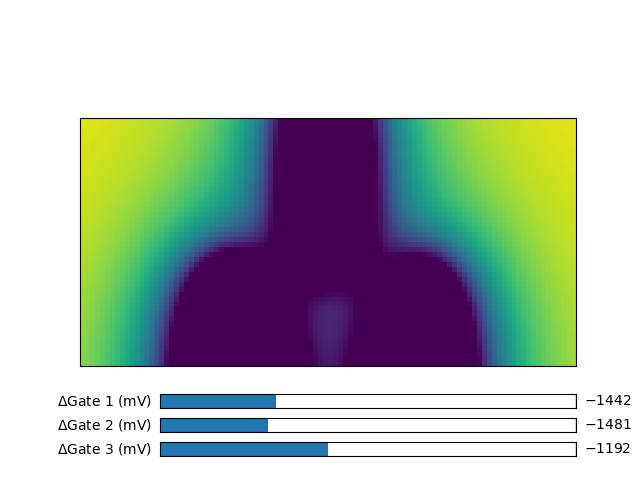

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button

lbar, rbar, nose = np.load("resources/lbar_pot.npy"), np.load("resources/rbar_pot.npy"), np.load("resources/nose_pot.npy")

def get_pot(gate1, gate2, gate3):
    return (lbar*gate2/1000.0 + rbar*gate3/1000.0 + nose*gate1/1000.0)[50:250,150:550][::4, ::4]

fig = plt.figure()
ax = fig.add_subplot(111)

gate1_slider1_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03])
gate1_slider1 = Slider(gate1_slider1_ax, '$\Delta$Gate 1 (mV)', -2000.0, 0.0, valinit=-0.0)
gate2_slider1_ax  = fig.add_axes([0.25, 0.1, 0.65, 0.03])
gate2_slider1 = Slider(gate2_slider1_ax, '$\Delta$Gate 2 (mV)', -2000.0, 0.0, valinit=-0.0)
gate3_slider1_ax  = fig.add_axes([0.25, 0.05, 0.65, 0.03])
gate3_slider1 = Slider(gate3_slider1_ax, '$\Delta$Gate 3 (mV)', -2000.0, 0.0, valinit=-0.0)

norm = get_pot(-400,-400,-400)
im = ax.imshow(get_pot(-0,-0,-0), vmax = norm.max(), vmin = norm.min())
ax.set_xticks([])
ax.set_yticks([])
def sim(val):
    '''
    Update function for plot
    '''
    im_new = get_pot(gate1_slider1.val,
                    gate2_slider1.val,
                    gate3_slider1.val)
    im.set_data(im_new)
    fig.canvas.draw_idle()
gate1_slider1.on_changed(sim)
gate2_slider1.on_changed(sim)
gate3_slider1.on_changed(sim)

plt.show()

## Unfortunately we can't see this

When tuning we don't directly observe the potential profile of the device. We can only observe the transport current through the device.

#### Gate voltage space in transport
<img style="float: right;" src="resources/poffvg.gif" width="500" height="500">


The voltage space of these devices is transistor like with the most negative (safe) regions of gate voltage space exhibiting no transport and the most positive (safe) exhibiting maximum transport.

The boundary that separates these regions high current and low current regimes is where tunnel barriers are forming in our device. Embedded in this boundary are transport features that indicate how many quantum dots have been formed in the device.
<img style="float: center;" src="resources/voltage_space.png" width="400" height="400">

#### How can you tell how many quantum dots have been formed?

<img style="float: left;" src="resources/zoom_voltage_space.png" width="180" height="300">



To infer how many quantum dots have been formed in the device we we must vary the two plunger gates ($V_{7}$ and $V_{3}$) in a raster pattern while observing the transport current. If the device is in a double dot regime (Top) we observe either a honeycomb like pattern or isolated points of current. If the device is in a single dot regime (Bottom) we observe only straight lines.

### The problems

- No two devices are the same. (we can't just copy an paste)

- A useful quantum computer will likely require $10^6 - 10^8$ devices.

- Measurements take a long time. (~5 mins for previously mentioned raster scan) 

- The device itself is 8 dimensional.

- Signal processing is typically unreliable.

## This is where Autodot can help!

Autodot is a random search based algorithm that uses few modeling assumptions in order to explore the gate voltage space of quantum devices and tune them. It is highly configurable and the settings that control it can be supplied via a configuration file or python dictionary.

In [2]:
import json
with open('AutoDot/mock_device_demo_config.json') as f:
    configs = json.load(f)
configs

{'playground': {'shapes': {'Crosstalk_box': {}, 'Leakage': {}},
  'ndim': 3,
  'plot': True},
 'plunger_gates': [1, 2],
 'save_dir': 'mock_device_demo/',
 'investigation': {'measurement_seq': ['diag_trace',
   '2d_lowres',
   '2d_highres'],
  'cond_meas': [False, {'quantile': 0.85, 'min_thresh': 0.001}, False],
  'diag_trace': {'func': 'mock_measurement',
   'condition': 'mock_peak_check',
   'a': [0, 0],
   'b': [-1000, -1000],
   'pause': 0.5,
   'verbose': True},
  '2d_lowres': {'func': 'mock_measurement',
   'condition': 'mock_score_func',
   'target': [-500, -250],
   'pause': 1.0},
  '2d_highres': {'func': 'mock_measurement',
   'condition': 'check_nothing',
   'pause': 1.0}},
 'detector': {'d_r': 20,
  'len_after_poff': 300,
  'th_high': 0.2,
  'th_low': 0.01},
 'general': {'directions': [-1.0, -1.0, -1.0],
  'lb_box': [-2000, -2000, -2000],
  'bound': [-2000, -2000, -2000],
  'num_samples': 50,
  'origin': [0, 0, 0],
  'ub_box': [0, 0, 0]},
 'gpc': {'gpc_start': 10,
  'gpc_on':

Let's use the above dictionary to configure a fake device for us to run live tests on.

In [3]:
from AutoDot.Playground.demo import create_mock_device_from_file, plot_device_demo, plot_gpr_demo
device, jump, measure, check, score = create_mock_device_from_file(configs)

### Have a go yourself!

Below is an interactive plot that allows you to navigate the fake device environment. Move around using the sliders and use the score button to score a point in gate voltage space. Try and get the highest score you can with as few evaluations as possible. Remember that in real life each evaluation can take up to 5 mins.

<IPython.core.display.Javascript object>


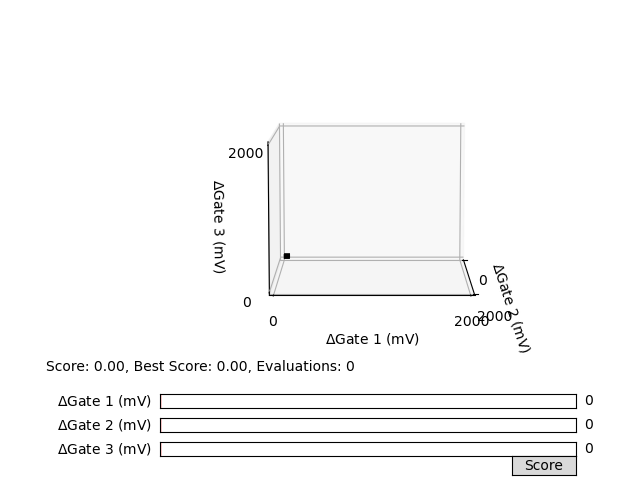

In [5]:
%matplotlib notebook
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def voxel_polly(cube, player_loc):
    val_t = cube[player_loc[0], player_loc[1], player_loc[2]]
    cube[player_loc[0], player_loc[1], player_loc[2]] = 0.5
    locs = np.array(np.where(~cube.mask)).T
    col = cube[~cube.mask]
    col_a = np.zeros([locs.shape[0], 4])
    col_a[col == 0.0] = [0.0, 0.1, 1.0, 0.1]
    col_a[col == 1.0] = [1.0, 0.1, 0.1, 0.8]
    col_a[col == 0.5] = [0.0, 0.0, 0.0, 1.0]
    cube[player_loc[0], player_loc[1], player_loc[2]] = val_t
    g = []
    for loc in locs:
        g.append( cuboid_data(loc))
    return np.concatenate(g), np.repeat(col_a,6, axis=0)

def add_sliders(ub, lb):
    gate1_slider2_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03])
    gate1_slider2 = Slider(gate1_slider2_ax, '$\Delta$Gate 1 (mV)', 0.0, ub[1] - lb[1], valinit=0.0)

    gate2_slider2_ax  = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    gate2_slider2 = Slider(gate2_slider2_ax, '$\Delta$Gate 2 (mV)', 0.0, ub[0] - lb[0], valinit=0.0)

    gate3_slider2_ax  = fig.add_axes([0.25, 0.05, 0.65, 0.03])
    gate3_slider2 = Slider(gate3_slider2_ax, '$\Delta$Gate 3 (mV)', 0.0, ub[2] - lb[2], valinit=0.0)
    return gate1_slider2, gate2_slider2, gate3_slider2
                                    
                                    
def config_axes(ax, ub, lb, res):
    ax.set_xlim([0.0,res])
    ax.set_xticks([0, res])
    ax.set_xticklabels([0, ub[0] - lb[0]])
    ax.set_xlabel('$\Delta$Gate 2 (mV)')

    ax.set_ylim([0.0,res])
    ax.set_yticks([0, res])
    ax.set_yticklabels([0, ub[1] - lb[1]])
    ax.set_ylabel('$\Delta$Gate 1 (mV)')

    ax.set_zlim([0.0,res])
    ax.set_zticks([0, res])
    ax.set_zticklabels([0, ub[2] - lb[2]])
    ax.set_zlabel('$\Delta$Gate 3 (mV)')
    
    ax.view_init(8, 0)
    return ax


def get_scores(sampler):
    scores = []
    for samp in sampler.t['extra_measure']:
        rs = samp.get('extra_measure', [])
        if len(rs) >1:
            scores.append(rs[1][0])
        else:
            scores.append(0.0)
    return scores

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy.ma as ma
from matplotlib.widgets import Slider, Button

#create empty grid of voxels res=30 and start at 0,0,0
res = 30
data = ma.array(np.empty([res]*3), mask = np.ones([res]*3))
scores = []
data[0,0,0] = 1.0

#extract upper and lower bound from configs to define grid
conf_g = configs['general']
lb, ub = conf_g['lb_box'], conf_g['ub_box']
grid = np.array(np.meshgrid(*[np.linspace(ub[i], lb[i], res) for i in range(3)]))

#plot voxels
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)
verts, c = voxel_polly(data, [0,0,0])
pc = Poly3DCollection(verts, facecolors = c)
ax.add_collection3d(pc)
text = ax.text(0.0, 0.0, 3,'Score: {:.2f}, Best Score: {:.2f}, Evaluations: {}'.format(0, 0, 0),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

#add details to the plot
ax = config_axes(ax, ub, lb, res)

#add sliders
gate1_slider2, gate2_slider2, gate3_slider2 = add_sliders(ub, lb)

#create update function. This measures the mock device and plots voxels 
#every time a slider is changed
def fill_array(val):
    '''
    Update function for plot
    '''
    idx = [(gate1_slider2.val/(ub[1] - lb[1]))*res, 
           (gate2_slider2.val/(ub[0] - lb[0]))*res, 
           (gate3_slider2.val/(ub[2] - lb[2]))*res]
    idx_int = np.round(idx).astype(int)
    jump(grid[:,idx_int[1], idx_int[0], idx_int[2]])
    data[idx_int[1], idx_int[0], idx_int[2]] = np.squeeze(measure())
    verts, c = voxel_polly(data, [idx_int[1], idx_int[0], idx_int[2]])
    pc.set_verts(verts)
    pc.set_facecolor(c)
    fig.canvas.draw_idle()
gate1_slider2.on_changed(fill_array)
gate2_slider2.on_changed(fill_array)
gate3_slider2.on_changed(fill_array)


#Add a button to allow you to score the regime you're in
resetax = plt.axes([0.8, 0.01, 0.1, 0.04])
button = Button(resetax, 'Score')
def investigate_regime(val):
    idx = [(gate1_slider2.val/(ub[1] - lb[1]))*res, 
           (gate2_slider2.val/(ub[0] - lb[0]))*res, 
           (gate3_slider2.val/(ub[2] - lb[2]))*res]
    idx_int = np.round(idx).astype(int)
    vol = grid[:,idx_int[1], idx_int[0], idx_int[2]]
    scores.append(score(vol))
    text.set_text('Score: {:.2f}, Best Score: {:.2f}, Evaluations: {}'.format(scores[-1], np.max(scores), len(scores)))
    fig.canvas.draw_idle() 
button.on_clicked(investigate_regime)

plt.show()

## What was I just measuring?

Bellow is a plot of the boundary between high and low current for the fake device Autodot created.

/home/dominic/AutoDot_demo/AutoDot/Playground/demo.py:226: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = marching_cubes_lewiner(vols,0)


<IPython.core.display.Javascript object>


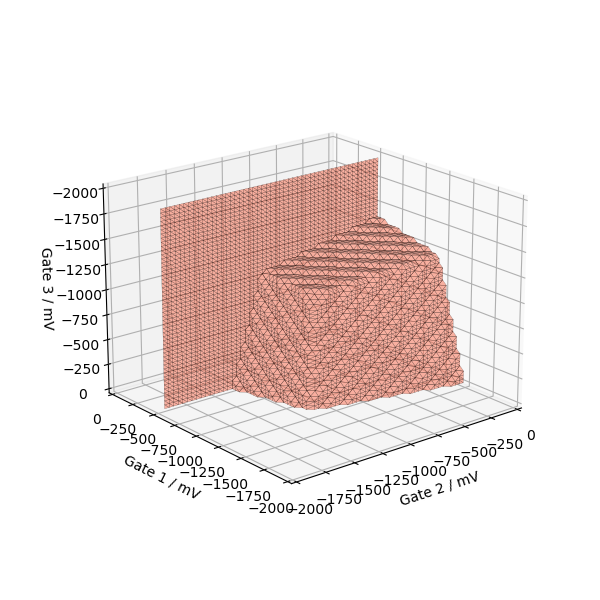

In [6]:
%matplotlib notebook
plot_device_demo(device, configs, cmap = 'Reds') 

### How does Autodot do?

In [7]:
from AutoDot.tune import tune_from_dict 
ret, sampler = tune_from_dict(jump, measure, check, configs)

reconstraining parameters basic.lengthscale
reconstraining parameters basic.lengthscale
reconstraining parameters basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance


============### ITERATION 0 ###============
GPR: False GPC: False prune: True GPR1: False GPC1: False Optim: False
dvec pinches:  [ True False False]
New origin:  [-36   0   0]
conditional_idx: 0
vols_pinchoff: [  -36.31751177  -465.62672709 -1985.81791445]
detected: False
r_vals: 2039.999999999998
============### ITERATION 1 ###============
GPR: False GPC: False prune: True GPR1: False GPC1: False Optim: False
False
dvec pinches:  [ True  True  True]
conditional_idx: 1
vols_pinchoff: [ -506.91223003  -474.24100735 -1275.51446035]
detected: True
r_vals: 1440.0000000000023
============### ITERATION 2 ###============
GPR: False GPC: False prune: True GPR1: False GPC1: False Optim: False
True
0.12021015923368411
Score thresh:  0.001
dvec pinches:  [ True  True  True]
conditional_idx: 3
vols_pinchoff: [-1041.77137424  -959.61758812  -943.37586747]
detected: True
r_vals: 1679.9999999999982
============### ITERATION 3 ###============
GPR: False GPC: False prune: True GPR1: False GPC1: False 

 /home/dominic/miniconda3/envs/demo_test/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


  sum.               |               value  |  constraints  |     priors    
  basic.variance     |   40.71339018454742  |      +ve      |  Ga(6.2, 0.12)
  basic.lengthscale  |                (3,)  |      +ve      |  Ga(25, 0.05) 
  bias.variance      |  31.768082414941087  |      +ve      |               
  index  |  gp_classification.sum.basic.lengthscale  |  constraints  |     priors   
  [0]    |                             484.90745906  |      +ve      |  Ga(25, 0.05)
  [1]    |                             488.21067428  |      +ve      |  Ga(25, 0.05)
  [2]    |                             482.37713520  |      +ve      |  Ga(25, 0.05)
  sum.               |                   value  |  constraints  |     priors    
  basic.variance     |       41.70154315076868  |      +ve      |  Ga(6.2, 0.12)
  basic.lengthscale  |                    (3,)  |      +ve      |  Ga(25, 0.05) 
  bias.variance      |  2.7691599724398813e-06  |      +ve      |               
  index  |  gp_classificatio

False
STOP
dvec pinches:  [ True  True  True]
There are 24 training examples for model 0 and 22 are positive
There are 22 training examples for model 1 and 8 are positive
conditional_idx: 1
vols_pinchoff: [ -972.27104908 -1230.9702325   -136.03335318]
detected: True
r_vals: 1492.6933468489146
============### ITERATION 24 ###============
GPR: True GPC: True prune: True GPR1: True GPC1: True Optim: False
START
False
STOP
dvec pinches:  [ True  True  True]
There are 25 training examples for model 0 and 23 are positive
There are 23 training examples for model 1 and 8 are positive
conditional_idx: 1
vols_pinchoff: [-1026.48532862 -1038.03947329  -865.90380575]
detected: True
r_vals: 1617.0793293628508
============### ITERATION 25 ###============
GPR: True GPC: True prune: True GPR1: True GPC1: True Optim: False
START
True
0.28112235639523825
Score thresh:  0.001
STOP
dvec pinches:  [ True  True  True]
There are 26 training examples for model 0 and 24 are positive
There are 24 training examp

True
0.2165236097743441
Score thresh:  0.32127999592524376
STOP
There are 38 training examples for model 0 and 34 are positive
There are 34 training examples for model 1 and 16 are positive
conditional_idx: 2
vols_pinchoff: [-1463.88787937   -73.4483234    -72.93223668]
detected: True
r_vals: 1328.9250017410654
============### ITERATION 38 ###============
GPR: True GPC: True prune: False GPR1: True GPC1: True Optim: False
START
False
STOP
There are 39 training examples for model 0 and 35 are positive
There are 35 training examples for model 1 and 16 are positive
conditional_idx: 1
vols_pinchoff: [ -500.21549667 -1871.38561913  -253.59227612]
detected: True
r_vals: 1922.724580650167
============### ITERATION 39 ###============
GPR: True GPC: True prune: False GPR1: True GPC1: True Optim: False
START
True
0.14680444692499087
Score thresh:  0.31731494452658515
STOP
There are 40 training examples for model 0 and 36 are positive
There are 36 training examples for model 1 and 17 are positive

 /home/dominic/AutoDot_demo/AutoDot/main_utils/utils.py:44: RuntimeWarning:invalid value encountered in true_divide
 /home/dominic/AutoDot_demo/AutoDot/Playground/demo.py:226: FutureWarning:marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


<IPython.core.display.Javascript object>


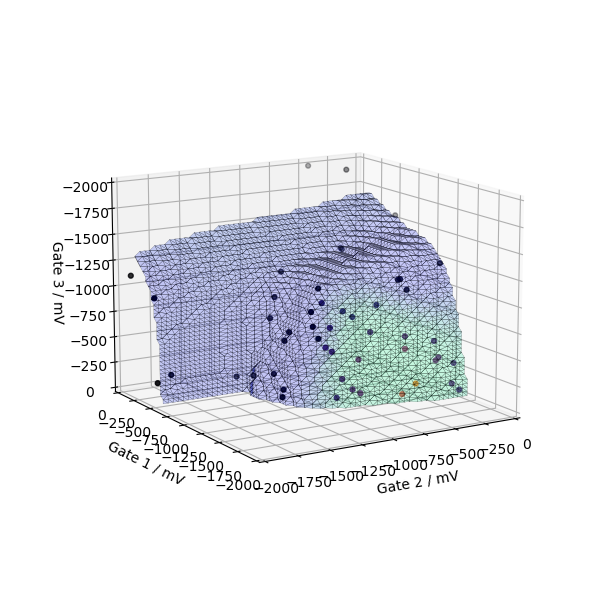

The best score found was:  0.6930714620751104


In [8]:
%matplotlib notebook
def get_scores(sampler):
    scores = []
    for samp in sampler.t['extra_measure']:
        rs = samp.get('extra_measure', [])
        if len(rs) >1:
            scores.append(rs[1][0])
        else:
            scores.append(0.0)
    return scores
scores = get_scores(sampler)
plot_gpr_demo(sampler.gpr, 
              configs,
              origin = sampler.t['origin'],
              obs = (ret['vols_pinchoff'], scores),
              cmap = ('winter', sampler.gpc.predict_comb_prob))
print("The best score found was: ", np.max(scores))

In the above you can see that the algorithm has produced a model of what it thinks the device looks like and where it thinks the score is greater then 0 (or where coulomb peaks are). You can also see the individual observation made by the algorithm and that samples are focused on the none 0 region. The observations are also colored according to the score they received and the best score is printed above.

## What else can we use this for?

As I mentioned earlier one of the issues that causes this problem is that no 2 devices are the same. We use the algorithm to quantify how different the devices are and identify which gates are responsible. 

We will do this by measuring point clouds on the pinch surface of 2 different devices and then use [point set registration](https://ieeexplore.ieee.org/document/5432191) to find the liner transformation between them.

Lets create two new fake devices that have different gate crosstalk (i.e. where the gate voltage on one quantum dot affects also the other quantum dot).

In [9]:
import copy
configs_dev1 = copy.deepcopy(configs)
configs_dev2 = copy.deepcopy(configs)
#create 2 new fake devices with different crosstalk
configs_dev1['playground'] = {'shapes': {'Crosstalk_box': {'a_prime': -1500}},
                              'ndim': 2}
configs_dev2['playground'] = {'shapes': {'Crosstalk_box': {'a_prime': [-1200,-1000]}},
                              'ndim': 2}
configs_dev1['plunger_gates'] = [0, 1]
configs_dev2['plunger_gates'] = [0, 1]

device1, jump1, measure1, check1, score1 = create_mock_device_from_file(configs_dev1)
device2, jump2, measure2, check2, score2 = create_mock_device_from_file(configs_dev2)

<IPython.core.display.Javascript object>


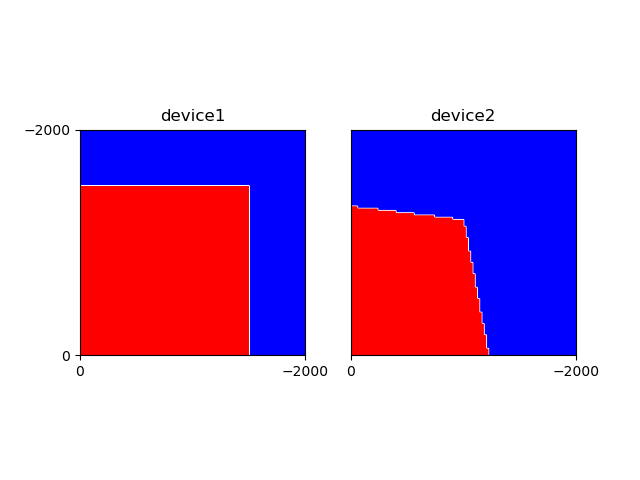

In [10]:
%matplotlib notebook
res = 100
x = np.linspace(0, -2000, res)
grid = np.array(np.meshgrid(x, x)).T.reshape([-1, 2])

cur1 = device1.arr_measure(grid).reshape([res, res])
cur2 = device2.arr_measure(grid).reshape([res, res])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cur1, cmap='bwr', origin = 'lower',extent = [0, -2000, 0, -2000])
axs[0].set_xticks([0, -2000])
axs[0].set_yticks([0, -2000])
axs[0].set_title("device1")
axs[1].imshow(cur2, cmap='bwr', origin = 'lower',extent = [0, -2000, 0, -2000])
axs[1].set_xticks([0, -2000])
axs[1].set_yticks([])
axs[1].set_title("device2")
plt.show()

Now lets alter the AutoDot configs to measure uniformly across the pinch surface in 2D.

In [11]:
def alter_configs(conf):
    #make the investigation stage do nothing
    conf['investigation'] = {'measurement_seq': ['do_nothing'],
                             'cond_meas': [False],
                             'do_nothing': {'func': 'mock_measurement',
                                            'condition': 'check_nothing',
                                            'pause': 1.0}}
    #switch off non uniform sampling methods
    conf['gpc']['gpc_on'] = False
    conf['pruning']['pruning_on'] = False
    
    #update the general configs for a 2D enviroment
    conf['general'] = {'directions': [-1.0, -1.0],
                          'lb_box': [-2000, -2000],
                          'bound': [-2000, -2000],
                          'num_samples': 20,
                          'origin': [0, 0],
                          'ub_box': [0, 0]}
    return conf
    
    
configs_dev1 = alter_configs(configs_dev1)
configs_dev2 = alter_configs(configs_dev2)

Run AutoDot on both

In [23]:
ret, sampler = tune_from_dict(jump1, measure1, check1, configs_dev1)
point_cloud1 = np.array(ret['vols_pinchoff'])

ret, sampler = tune_from_dict(jump2, measure2, check2, configs_dev2)
point_cloud2 = np.array(ret['vols_pinchoff'])

reconstraining parameters basic.lengthscale
reconstraining parameters basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance


============### ITERATION 0 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [ -603.57952721 -1503.36015457]
detected: True
r_vals: 1619.9999999999993
============### ITERATION 1 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [ -324.992779   -1505.31714054]
detected: True
r_vals: 1540.000000000001
============### ITERATION 2 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [-1340.06663651 -1511.49641406]
detected: True
r_vals: 2020.000000000001
============### ITERATION 3 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [ -977.6961066  -1511.32733818]
detected: True
r_vals: 1799.9999999999986
============### ITERATION 4 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Opt

reconstraining parameters basic.lengthscale
reconstraining parameters basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.lengthscale
reconstraining parameters sum.basic.variance


STOP
conditional_idx: 1
vols_pinchoff: [-1502.55888225 -1063.8529269 ]
detected: True
r_vals: 1841.0503102011426
============### ITERATION 0 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [ -941.6909129  -1062.83499404]
detected: True
r_vals: 1419.9999999999998
============### ITERATION 1 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [ -878.64346526 -1064.13611016]
detected: True
r_vals: 1379.9999999999989
============### ITERATION 2 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [-1230.29196721  -892.62627982]
detected: True
r_vals: 1520.0000000000018
============### ITERATION 3 ###============
GPR: False GPC: False prune: False GPR1: False GPC1: False Optim: False
conditional_idx: 1
vols_pinchoff: [-1263.91655923  -553.99903547]
detected: True
r_vals: 1379.99999

lets see the point clouds AutoDot measured

<IPython.core.display.Javascript object>


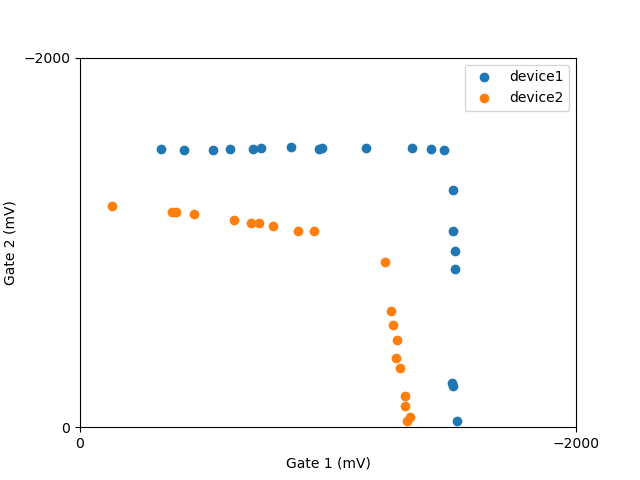

In [24]:
%matplotlib notebook
res = 100
x = np.linspace(0, -2000, res)
grid = np.array(np.meshgrid(x, x)).T.reshape([-1, 2])

cur1 = device1.arr_measure(grid).reshape([res, res])
cur2 = device2.arr_measure(grid).reshape([res, res])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(*point_cloud1.T, label = 'device1')
ax.scatter(*point_cloud2.T, label = 'device2')
ax.set_xticks([0, -2000])
ax.set_yticks([0, -2000])
ax.set_xlim([0, -2000])
ax.set_ylim([0, -2000])
ax.set_xlabel('Gate 1 (mV)')
ax.set_ylabel('Gate 2 (mV)')
ax.legend()
plt.show()

Now we can easily apply registration to the point clouds and check the results

In [25]:
from AutoDot.perform_registration import register_point_clouds
reg_params, point_cloud_reg = register_point_clouds(point_cloud1, point_cloud2)

1 532.0206687527152 622.5995508622003
2 15.570194037502688 623.780656948788
3 9.553510008960785 648.9391023720958
4 10.291183749288933 674.7666169315396
5 10.303902828653975 693.6331932838078
6 9.749195600933774 704.2507388035457
7 8.060858603847862 709.3931589911092
8 5.3372180264256315 711.8150269536017
9 2.914844654153768 713.3871242034913
10 1.6959599502207539 714.9026446194846
11 1.3004171251515118 716.3906192072604
12 1.1989622177354704 717.6831464206615
13 1.0999631844646558 718.6666110745934
14 0.9521563114518301 719.3418359735421
15 0.7911965670192842 719.7788841728059
16 0.6470378003358235 720.0572312819246
17 0.5286939890013969 720.2375532477056
18 0.4339706022494738 720.3587930382157
19 0.3578652728770635 720.4439924381226
20 0.29594256674826624 720.5063959547035
21 0.24497700931274835 720.5536624498709
22 0.2027216345872489 720.5903595487347
23 0.16756981512168068 720.6193425390004
24 0.1383100183640238 720.642495638922
25 0.11397995449209475 720.6611295695957
26 0.0937865

<IPython.core.display.Javascript object>


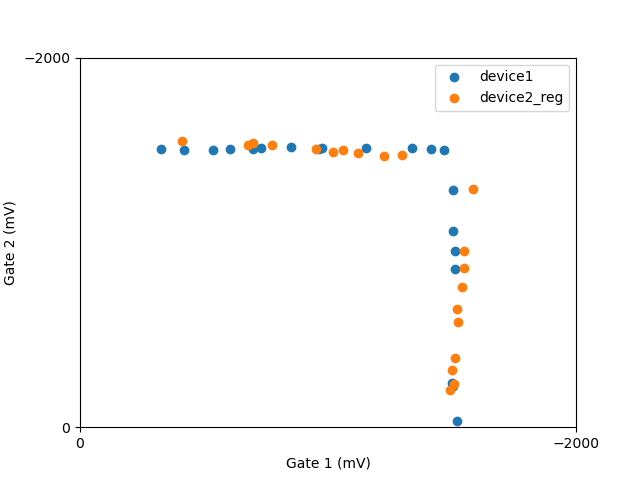

In [26]:
%matplotlib notebook
res = 100
x = np.linspace(0, -2000, res)
grid = np.array(np.meshgrid(x, x)).T.reshape([-1, 2])

cur1 = device1.arr_measure(grid).reshape([res, res])
cur2 = device2.arr_measure(grid).reshape([res, res])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(*point_cloud1.T, label = 'device1')
ax.scatter(*point_cloud_reg.T, label = 'device2_reg')
ax.set_xticks([0, -2000])
ax.set_yticks([0, -2000])
ax.set_xlim([0, -2000])
ax.set_ylim([0, -2000])
ax.set_xlabel('Gate 1 (mV)')
ax.set_ylabel('Gate 2 (mV)')
ax.legend()
plt.show()

# I hope you found that interesting!

If you're interested in playing around here is some information about what specific parts of the config file do.

In [61]:
configs.keys()

dict_keys(['playground', 'plunger_gates', 'save_dir', 'investigation', 'detector', 'general', 'gpc', 'gpr', 'pruning', 'sampling', 'track', 'verbose', 'jump', 'measure', 'investigation_stage_class'])

##### playground
playground is used by the 'Playground' module to build a fake device when using functions like tune_with_playground_from_file. It specifies the shape and dimensionality of the fake device. The 'shapes' key allows the user to build a device using the shapes in Playground/shapes.py

In [62]:
configs['playground']

{'shapes': {'Crosstalk_box': {}, 'Leakage': {}}, 'ndim': 3, 'plot': True}

##### plunger_gates
Used to specify which gates to use in the investigation stage in the playground the values are a list of 0 based indexes.

In [63]:
configs['plunger_gates']

[1, 2]

##### save_dir
location to save results to.

In [64]:
configs['save_dir']

'mock_device_demo/'

##### investigation
configures what the investigation stage does and is looking for. In the case below 'measurement_seq' states that first 'diag_trace' should be performed, then '2d_lowres', then finally 2d_highres. What each of those do and is looking for is specified in their associated dictionary. For example in the case below as this is only a demo 2d_highres only pretends to measure (with a 1 second pause) and then checks for nothing returning false by default.

In [6]:
configs['investigation']

{'measurement_seq': ['diag_trace', '2d_lowres', '2d_highres'],
 'cond_meas': [False, {'quantile': 0.85, 'min_thresh': 0.001}, False],
 'diag_trace': {'func': 'mock_measurement',
  'condition': 'mock_peak_check',
  'a': [0, 0],
  'b': [-1000, -1000],
  'pause': 0.5,
  'verbose': True},
 '2d_lowres': {'func': 'mock_measurement',
  'condition': 'mock_score_func',
  'target': [-500, -250],
  'pause': 1.0},
 '2d_highres': {'func': 'mock_measurement',
  'condition': 'check_nothing',
  'pause': 1.0}}

##### detector
specifies how the hypersurface is measured and identified. d_r controls the spacing between points in the ray that finds the pinch. th_low specifies the value that current must fall below to be considered pinched, in this case it must fall below 1% the difference between the current at [0,0,0] and [-2000, -2000, -2000]. len_after_poff states how far in mV the detector must continue in order to confirm that the current has fallen below the threshold.

In [7]:
configs['detector']

{'d_r': 20, 'len_after_poff': 300, 'th_high': 0.2, 'th_low': 0.01}

##### general
specifies general behavior of the algorithm like safe bounds and the number of iterations to perform.

In [8]:
configs['general']

{'directions': [-1.0, -1.0, -1.0],
 'lb_box': [-2000, -2000, -2000],
 'bound': [-2000, -2000, -2000],
 'num_samples': 50,
 'origin': [0, 0, 0],
 'ub_box': [0, 0, 0]}

##### gpc
specifies whether the gaussian process classifier is used for thompson sampling, which parts of the investigation stage are to be modelled and the piors of the models.

In [9]:
configs['gpc']

{'gpc_start': 10,
 'gpc_on': True,
 'gpc_list': [True, True, False],
 'configs': {'length_prior_mean': 500.0,
  'length_prior_var': 100.0,
  'var_prior_mean': 50.0,
  'var_prior_var': 20.0,
  'kernal': 'Matern52'}}

##### gpr
specifies if the gaussian process regression is used for uniform sampling of the surface and reducing surface finding times along with it's prior.

In [10]:
configs['gpr']

{'restarts': 5,
 'factor_std': 2.0,
 'gpr_start': 10,
 'gpr_on': True,
 'length_prior_mean': 0.4,
 'length_prior_var': 0.1,
 'r_min': 0.0,
 'var_prior_mean_divisor': 4.0,
 'kernal': 'Matern52'}

##### pruning
specifies if the pruning rule is applied and if so how and for how long.

In [11]:
configs['pruning']

{'pruning_stop': 30, 'pruning_on': True, 'step_back': 100}

##### sampling
specifies details about the brownian motion sampler

In [12]:
configs['sampling']

{'max_steps': 100000, 'n_part': 200, 'sigma': 25}

##### track
A list of tuning algorithm parameters for the algorithm to track and save with every iteration

In [13]:
configs['track']

['origin',
 'bound',
 'directions',
 'samples',
 'extra_measure',
 'd_vec',
 'poff_vec',
 'meas_each_axis',
 'vols_each_axis',
 'conditional_idx',
 'vols_pinchoff',
 'detected',
 'r_vals',
 'times',
 'poff_traces']

##### verbose
a list of parameters to print out with every iteration

In [14]:
configs['verbose']

['conditional_idx', 'vols_pinchoff', 'detected', 'r_vals']